### Imports

In [20]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

import seaborn as sns
import pandas as pd

### Pre-processing the data

In [3]:
data = pd.read_csv("heart.csv")
t = data.iloc[:,-1] #last column of data, targets
X_pre = data.drop(data.columns[-1], axis=1) #remove target column from the data

#Center the data
mean = np.mean(X_pre, axis=0)
X_c = X_pre - mean

#normalize the data
min_X = X_c.min()
max_X = X_c.max()
X = (X_c - min_X) / (max_X - min_X)

    
X_numpy = X.to_numpy()
t_numpy = t.to_numpy()

#Split into train-test
X_train, X_test, t_train, t_test = train_test_split(X_numpy, t_numpy, test_size=0.2, random_state=42)

### PCA

In [4]:
pca_train = PCA(n_components=6)
pca_train.fit(X_train)
X_pca_train = pca_train.transform(X_train)

pca_test = PCA(n_components=6)
pca_test.fit(X_test)
X_pca_test = pca_test.transform(X_test)

### k-NN algorithm

In [5]:
knn = KNeighborsClassifier(n_neighbors=36, p=1, metric='minkowski')
knn.fit(X_pca_train, t_train)
t_pred = knn.predict(X_pca_test)

accuracy_test = knn.score(X_pca_test, t_test)
accuracy_train = knn.score(X_pca_train, t_train)

print(f"Accuracy score for Test-set: {accuracy_test}")
print(f"Accuracy score for Train-set: {accuracy_train}")

Accuracy score for Test-set: 0.7868852459016393
Accuracy score for Train-set: 0.7768595041322314


Alright let us try to find some optimal k-value

Highest accuracy of Test-set without PCA: 0.9016393442622951, with k value of: 35
Highest accuracy of Test-set with PCA: 0.8032786885245902, with k value of :33


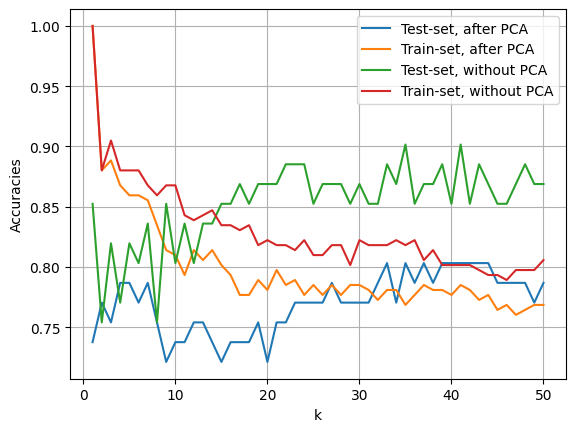

In [6]:
accuracies_test_pca = list()
accuracies_train_pca = list()
accuracies_test = list()
accuracies_train = list()

k = list()
for i in range(50):
    knn = KNeighborsClassifier(n_neighbors=i+1, p=1, metric='minkowski')
    knn.fit(X_pca_train, t_train)
    t_pred_pca = knn.predict(X_pca_test)
    accuracy_test_pca = knn.score(X_pca_test, t_test)
    accuracy_train_pca = knn.score(X_pca_train, t_train)

    knn.fit(X_train, t_train)
    t_pred = knn.predict(X_test)
    accuracy_test = knn.score(X_test, t_test)
    accuracy_train = knn.score(X_train, t_train)

    

    accuracies_test_pca.append(accuracy_test_pca)
    accuracies_train_pca.append(accuracy_train_pca)
    accuracies_test.append(accuracy_test)
    accuracies_train.append(accuracy_train)
    k.append(i+1)

plt.plot(k, accuracies_test_pca,"-", label="Test-set, after PCA")
plt.plot(k, accuracies_train_pca, "-", label="Train-set, after PCA")
plt.plot(k, accuracies_test,"-", label="Test-set, without PCA")
plt.plot(k, accuracies_train, "-", label="Train-set, without PCA")
plt.ylabel("Accuracies")
plt.xlabel("k")
plt.legend()
plt.grid(1)

print(f"Highest accuracy of Test-set without PCA: {max(accuracies_test)}, with k value of: {k[accuracies_test.index(max(accuracies_test))]}")
print(f"Highest accuracy of Test-set with PCA: {max(accuracies_test_pca)}, with k value of :{k[accuracies_test_pca.index(max(accuracies_test_pca))]}")


From the figure plottet, it is clear that the PCA worsens the results

### Further improvement to the model

It seems that by not including PCA, we get a better accuracy. Another hyperparameter in kNN algorithm is the test-set size. Let us try to perform a grid search between k-value and test-set size for a dataset which is without PCA.

In [7]:
test_sizes = np.arange(0.1, 0.6, 0.05)
k_values = np.arange(1, 40, 1)


accuracy_results = np.zeros([len(test_sizes), len(k_values)])

for i, test_size in enumerate(test_sizes):
    for j, k in enumerate(k_values):
        X_train, X_test, t_train, t_test = train_test_split(X_numpy, t_numpy, test_size=test_size, random_state=42)
        knn = KNeighborsClassifier(n_neighbors=k, p=1, metric='minkowski')
        knn.fit(X_train, t_train)
        accuracy = np.round(knn.score(X_test, t_test), 3)
        accuracy_results[i, j] = accuracy

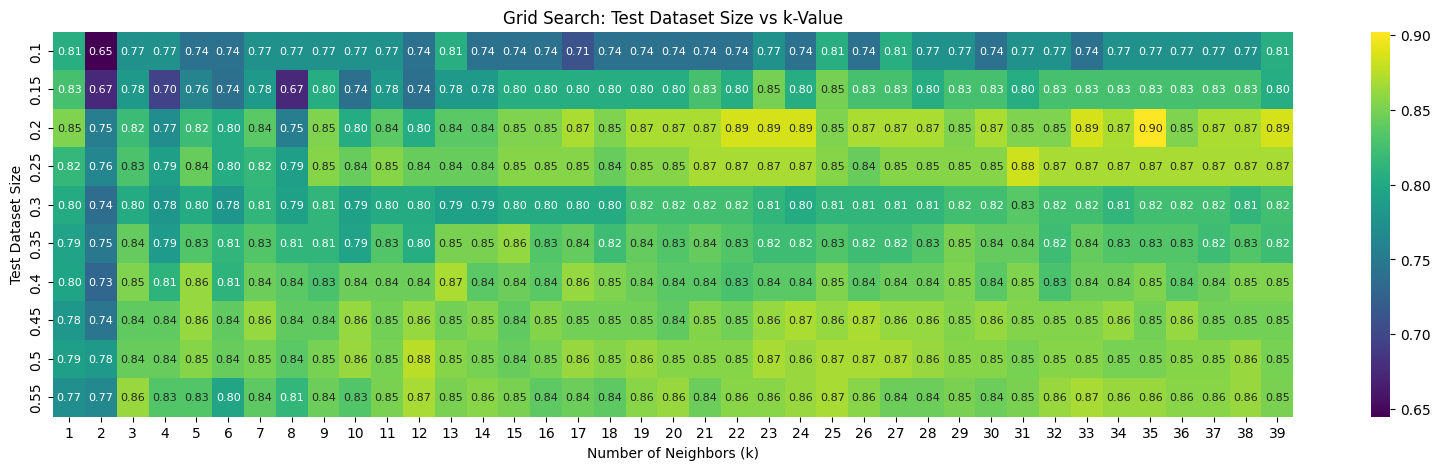

In [8]:
plt.figure(figsize=(20,5))
sns.heatmap(accuracy_results, annot=True, fmt=".2f", xticklabels=k_values, yticklabels=np.round(test_sizes,2), cmap='viridis', annot_kws={"size":8})
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Test Dataset Size')
plt.title('Grid Search: Test Dataset Size vs k-Value')
plt.show()


Seems like the most optimal combination of test-set size is 20% of the whole dataset, and the most optimal k-value is 35.

### Further evaluation

Since we found now most optimal hyperparameters, which are

test-set size: 20%
k-value: 35
PCA: No
Distance measurement: Manhattan

We will provide accuracy, precision, recall and f1 score

Accuracy score for Test-set: 0.902
Accuracy score for Train-set: 0.818
Precision: 0.903
Recall: 0.902
F1 Score: 0.901
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.86      0.89        29
           1       0.88      0.94      0.91        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



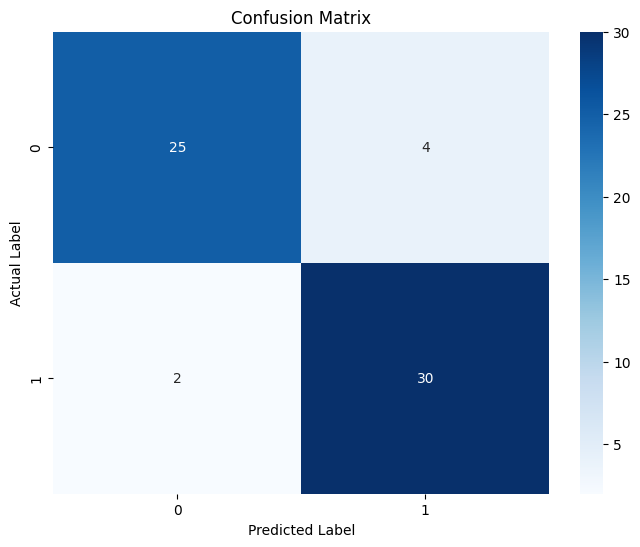

In [26]:
X_train, X_test, t_train, t_test = train_test_split(X_numpy, t_numpy, test_size=0.2, random_state=42)
knn = KNeighborsClassifier(n_neighbors=35, p=1, metric='minkowski')
knn.fit(X_train, t_train)
t_pred = knn.predict(X_test)

accuracy_test = knn.score(X_test, t_test)
accuracy_train = knn.score(X_train, t_train)

print(f"Accuracy score for Test-set: {np.round(accuracy_test, 3)}")
print(f"Accuracy score for Train-set: {np.round(accuracy_train,3)}")

precision = precision_score(t_test, t_pred, average='weighted')
recall = recall_score(t_test, t_pred, average='weighted')
f1 = f1_score(t_test, t_pred, average='weighted')

print(f"Precision: {np.round(precision,3)}")
print(f"Recall: {np.round(recall,3)}")
print(f"F1 Score: {np.round(f1,3)}")


print("Classification Report:\n", classification_report(t_test, t_pred))


conf_matrix = confusion_matrix(t_test, t_pred)


plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=set(t_test), yticklabels=set(t_test))
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()